In [1]:
from funcs import *
from tqdm import tqdm
import matplotlib
%matplotlib widget

In [2]:
@jit(nopython=True)
def F(u):
    return u**2.0

@jit(nopython=True)
def leftGU(x,y):
    return 0.0

@jit(nopython=True)
def rightGU(x,y):
    return 0.0

NU_ = Distrib(make_func("triangle_m_f", [-0.5,0.0,0.5]), supp_of_func=(-0.5,0.0,0.5))

def NU(x,y,xgrid,ygrid):
    return NU_(x)*NU_(y)  
    # return 0.0
    # mu = xgrid[int(len(xgrid)/2)]
    # sigma = 0.05
    # return np.exp(-0.5*np.square((x-mu)/sigma))*10.0
    # print(int(len(xgrid)/2))
    # print(x)
    # if x == xgrid[int(len(xgrid)/2)]:
    #     return 10.0
    # else:
        # return 0.0

@jit(nopython =True)
def D(x,y,u):
    mu1 = 0.25
    sigma = 0.05
    mu2 = -0.25
    # return u**2.0*(1.0 - np.exp(-0.5*np.square((x-mu1)/sigma)))*(1.0 - np.exp(-0.5*np.square((x-mu2)/sigma)))
    return u**2.0

@jit(nopython=True)
def K(xl,xr,ul,ur):
    return 0.5*(D(xl,ul)+D(xr,ur))

@jit(nopython=True)
def phi(x, u_tau_pola_i, u_i):
    return 0.5*(F(u_tau_pola_i)+F(u_i))

In [3]:
@jit(nopython = True)
def solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_,eps=0.01):
    u = np.copy(u_)    
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))

    By = np.zeros(shape=(Ny,))
    Ay = np.zeros(shape=(Ny, Ny))
    end_ = False
    for k in range(Nt-1):
        u_s = np.copy(u[k])        
        for j in range(1,Ny-1):
            for s in range(20):
                A[0][0] = -1.0/hx
                A[0][1] = 1.0/hx
                A[Nx-1][Nx-1] = 1.0/hx 
                A[Nx-1][Nx-2] = -1.0/hx
                for i in range(1,Nx-1):
                    A[i][i-1] = 1.0/(4*hx**2)*D(x[i+1],y[j],u_s[i+1][j]) - 1.0/(4.0*hx**2)*D(x[i-1],y[j],u_s[i-1][j]) - 1.0/hx**2*D(x[i],y[j],u_s[i][j])
                    A[i][i]   = 2.0/tau+2.0/(hx**2)*D(x[i],y[j],u_s[i][j])
                    A[i][i+1] = -1.0/(4*hx**2)*D(x[i+1],y[j],u_s[i+1][j]) + 1.0/(4.0*hx**2)*D(x[i-1],y[j],u_s[i-1][j]) - 1.0/hx**2*D(x[i],y[j],u_s[i][j])
                B[0] = leftGU(x[0],y[j])
                B[Nx-1] = rightGU(x[Nx-1],y[j])
                for i in range(1,Nx-1):
                    B[i] = F(u_s[i][j])+2.0/tau*u[k][i][j] + \
                        1.0/(4.0*hy**2)*(D(x[i],y[j+1],u[k][i][j+1])-D(x[i],y[j-1],u[k][i][j-1]))*(u[k][i][j+1]-u[k][i][j-1])+\
                        1.0/(hy**2)*D(x[i],y[j],u[k][i][j])*(u[k][i][j+1]-2.0*u[k][i][j]+u[k][i][j-1])
                u_s[:,j] = progonka(A,B)
        
        u_tau_pola = np.copy(u_s)
        for i in range(1,Nx-1):
            for s in range(20):
                Ay[0][0] = -1.0/hy
                Ay[0][1] = 1.0/hy
                Ay[Ny-1][Ny-1] = 1.0/hy 
                Ay[Ny-1][Ny-2] = -1.0/hy

                for j in range(1,Ny-1):
                    Ay[j][j-1] = 1.0/(4*hy**2)*D(x[i],y[j+1],u_s[i][j+1]) - 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1]) - 1.0/hy**2*D(x[i],y[j],u_s[i][j])
                    Ay[j][j]   = 2.0/tau+2.0/(hy**2)*D(x[i],y[j],u_s[i][j])
                    Ay[j][j+1] = -1.0/(4*hy**2)*D(x[i],y[j+1],u_s[i][j+1]) + 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1]) - 1.0/hy**2*D(x[i],y[j],u_s[i][j])

                By[0] = leftGU(x[i],y[0])
                By[Ny-1] = rightGU(x[i],y[Ny-1])
                for j in range(1,Ny-1):
                    By[j] = F(u_s[i][j])+2.0/tau*u_tau_pola[i][j] + \
                        1.0/(4.0*hx**2)*(D(x[i+1],y[j],u_tau_pola[i+1][j])-D(x[i-1],y[j],u_tau_pola[i-1][j]))*(u_tau_pola[i+1][j]-u_tau_pola[i-1][j])+\
                        1.0/(hx**2)*D(x[i],y[j],u_tau_pola[i][j])*(u_tau_pola[i+1][j]-2.0*u_tau_pola[i][j]+u_tau_pola[i-1][j])
                u_s[i,:] = progonka(Ay,By)

        if np.sum(np.isnan(u_s)) > 0 or np.sum(np.isinf(u_s)) > 0 or np.sum(u_s < 0.0) > 0:
            end_ = True
        if end_:
            return u[:k+1]
        u[k+1] = np.copy(u_s)
    return u

In [4]:
hx = 0.01
ax= -1.0
bx = 1.0
Nx=  int((bx-ax)/hx)+1
xgrid = np.linspace(ax,bx,num=Nx)

hy = 0.01
ay= -1.0
by = 1.0
Ny=  int((by-ay)/hy)+1
ygrid = np.linspace(ay,by,num=Ny)

tau = 0.01
T = 10.0
t0 = 0.0
Nt = int((t0+T-t0)/tau) + 1
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
y= np.copy(ygrid)
u = np.zeros(shape=(len(tgrid),len(xgrid),len(ygrid)))

In [5]:
for i in range(len(x)):
    for j in range(len(y)):
        u[0][i][j] = NU(x[i],y[j],x,y)

Text(0.5, 0.5, 'y')

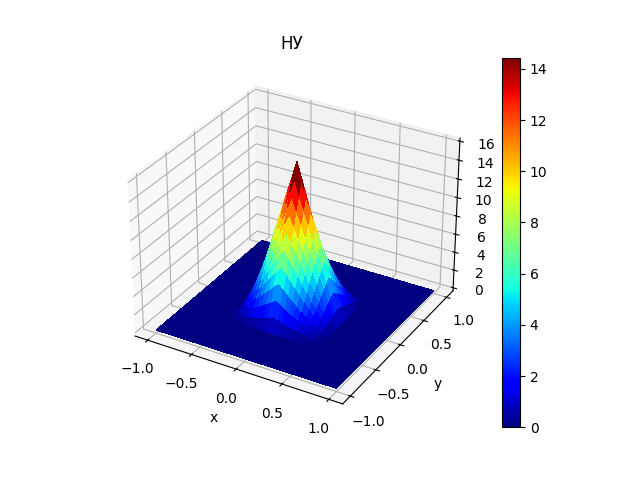

In [10]:
# fig,ax = plt.subplots()
# cax = ax.matshow(u[0],cmap=matplotlib.cm.jet)
# ax.invert_yaxis()
# fig.colorbar(cax)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u[0], cmap=matplotlib.cm.jet,
                       linewidth=0, antialiased=False)
fig.colorbar(surf)
ax.set_title('НУ')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [7]:
u = solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u,eps=0.0)

Text(0.5, 0.5, 'y')

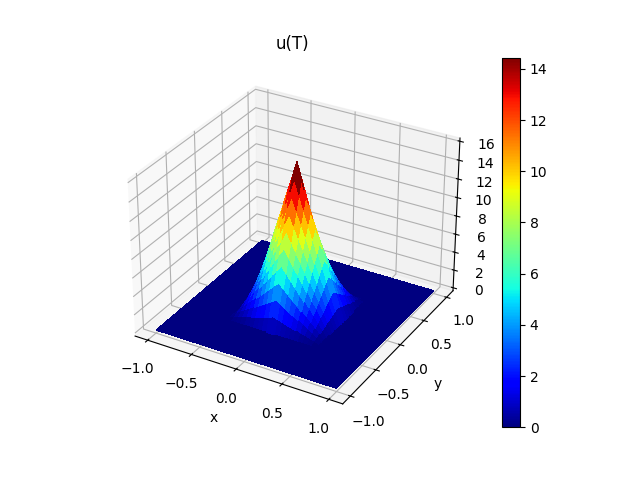

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u[-1], cmap=matplotlib.cm.jet,
                       linewidth=0, antialiased=False)
fig.colorbar(surf)
ax.set_title('u(T)')
ax.set_xlabel('x')
ax.set_ylabel('y')